In [3]:
from aqua.graphics import plot_hovmoller
from teleconnections import mjo_hovmoller
from aqua import Reader

In [4]:
%reload_ext autoreload
%autoreload 2

MJO is a teleconnection that require daily aggregated data.
We specify the teleconnection name and the model/exp/source to analyze.

In [5]:
from aqua import inspect_catalogue

inspect_catalogue(model='ERA5', exp='era5')

Sources available in catalogue for model ERA5 and exp era5:


['monthly', 'daily', 'hourly']

In [6]:
telecname = 'MJO'

model = 'ERA5'
exp = 'era5'
source = 'daily'

[autoreload of aqua.util.coord failed: Traceback (most recent call last):
  File "/work/bb1153/b382289/mambaforge/envs/aqua/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/work/bb1153/b382289/mambaforge/envs/aqua/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/work/bb1153/b382289/mambaforge/envs/aqua/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/b/b382289/src/AQUA/aqua/util/coor

The Reader class is user to retrieve the data, with standard resolution `r025` and the `daily` frequency.

In [7]:
reader = Reader(model=model,exp=exp,source=source, regrid='r025')
data = reader.retrieve()

2024-04-18 17:47:07 :: Reader :: WARNING  -> LRA_LUMI parameter is required but is missing, setting to default /work/bb1153/b382076/LRA-lumi
2024-04-18 17:47:32 :: Reader :: ERROR    -> Variable time_bnds has no units!


In order to plot the data we subselect a time slice of data, then we use the `Reader` methods to obtain the correctly formatted data for the plot

In [8]:
sel = {'time': slice('2021-01-01','2021-06-30')}

data_sel = data.sel(**sel)
data_sel = reader.timmean(data_sel, freq='daily')
data_sel = reader.regrid(data_sel)

[autoreload of aqua.util.coord failed: Traceback (most recent call last):
  File "/work/bb1153/b382289/mambaforge/envs/aqua/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/work/bb1153/b382289/mambaforge/envs/aqua/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/work/bb1153/b382289/mambaforge/envs/aqua/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/b/b382289/src/AQUA/aqua/util/coor

Finally the data are smoothed with a 5 days rolling window, selecting the correct variable and ready to be plotted.

In [9]:
data_sel

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 181, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2021-01-01 2021-01-02 ... 2021-06-30
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    mtntrf   (time, lat, lon) float64 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Sat Nov 18 14:40:07 2023: cdo -O -s -f nc4 -z zip -daymean ...
    frequency:    day
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

In [10]:
data_smooth = mjo_hovmoller(data_sel, telecname=telecname, loglevel='DEBUG', day_window=None)

[autoreload of aqua.util.coord failed: Traceback (most recent call last):
  File "/work/bb1153/b382289/mambaforge/envs/aqua/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/work/bb1153/b382289/mambaforge/envs/aqua/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/work/bb1153/b382289/mambaforge/envs/aqua/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/b/b382289/src/AQUA/aqua/util/coor

To plot we use the `plot_hovmoller` function from the framework

In [11]:
data_smooth

<xarray.DataArray 'mtntrf' (time: 181, lat: 120, lon: 681)> Size: 118MB
dask.array<sub, shape=(181, 120, 681), dtype=float64, chunksize=(1, 120, 681), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1kB 2021-01-01 2021-01-02 ... 2021-06-30
  * lat      (lat) float64 960B -14.88 -14.62 -14.38 ... 14.38 14.62 14.88
  * lon      (lon) float64 5kB 30.0 30.25 30.5 30.75 ... 199.2 199.5 199.8 200.0
Attributes: (12/16)
    standard_name:  toa_outgoing_longwave_flux
    long_name:      Mean top net thermal radiation flux
    units:          W m**-2
    code:           179
    table:          128
    cell_methods:   time: mean
    ...             ...
    derived:        TTR*24
    factor:         1.1574074074074073e-05
    offset:         0
    src_units:      J m**-2 day**-1
    units_fixed:    1
    regridded:      1

2024-04-18 17:52:26 :: Hovmoller :: INFO     -> Averaging over dimension: lat
2024-04-18 17:52:27 :: Hovmoller :: DEBUG    -> Setting vmin to -90, vmax to 90


/work/bb1153/b382289/mambaforge/envs/aqua/lib/python3.12/site-packages/sparse/_coo/core.py:215: DeprecationWarning: coords should be an ndarray. This will raise a ValueError in the future.
  warnings.warn(


(<Figure size 800x1300 with 2 Axes>, <Axes: xlabel='lon', ylabel='time'>)

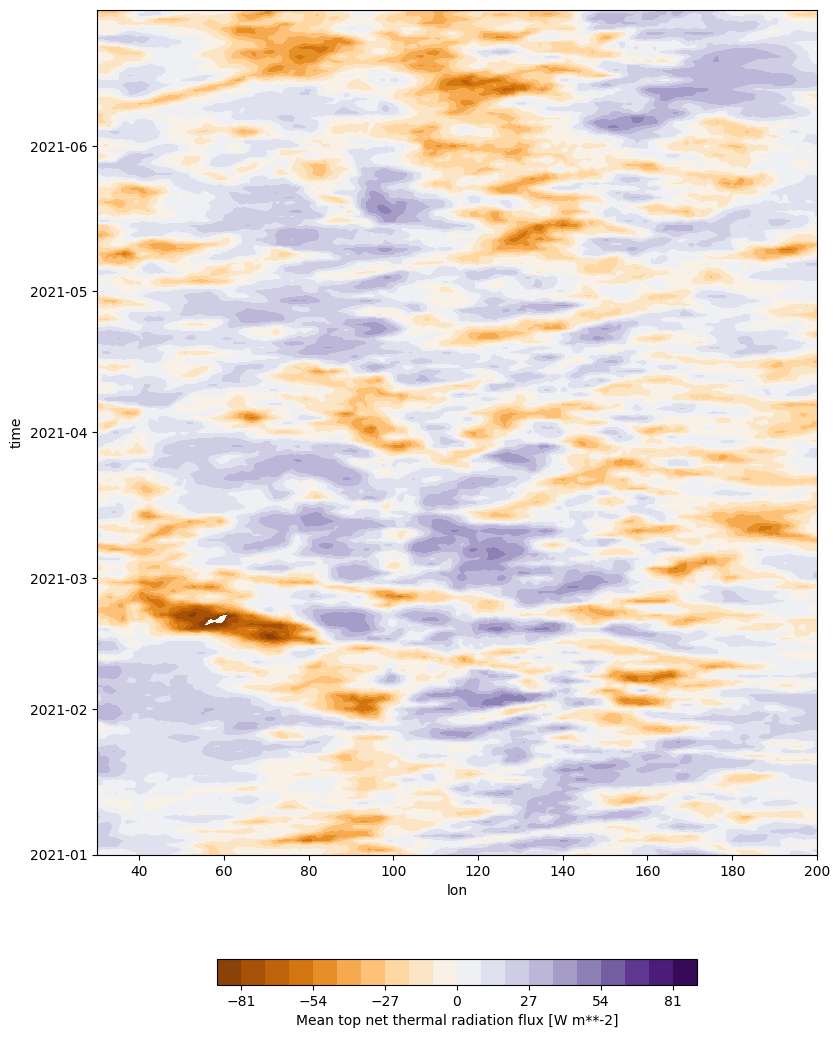

In [15]:
plot_hovmoller(data_smooth, dim='lat', invert_axis=True, invert_time=True, nlevels=21, loglevel='DEBUG', cmap='PuOr', vmin=-90, vmax=90)